# Choose optimization routine for identifying the revenue-neutral UBI level in Andrew Yang's Freedom Dividend

Try the four methods in `skopt`:
* `gp_minimize` (Gaussian)
* `dummy_minimize`
* `forest_minimize`
* `gbrt_minimize`

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import skopt

/home/max/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
tc.__version__

'2.2.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#eeeeee'  # Previously lighter #f5f5f5.

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Major parameters

In [6]:
UBI_MAX = 1000 * 12  # Maximum amount to test.
TOTAL_VAT = 800e9
TOTAL_FTT = 50e9
CARBON_FEE = 20  # It's actually $40, but half goes to clean energy projects.
CARBON_FEE_TPC = 49  # Fee from the paper.
CARBON_FEE_UBI_SHARE = 0.5  # Half goes to UBI, half to other projects.
PCT_CITIZEN = 0.93
# Yang's plan wouldn't be enacted until 2021, but 
# this allows people to enter current income.
YEAR = 2019

In [7]:
N_CALLS = 50

## Data

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

Exclude Medicaid and Medicare from `aftertax_income`.

NB: This is equivalent to setting their consumption value to zero, which would be an assumption rather than a reform.

In [10]:
MCAID_MCARE_REPEAL_REFORM = {
    'BEN_mcaid_repeal': {2019: True},
    'BEN_mcare_repeal': {2019: True},
}

In [11]:
YANG_REFORM = {
    'SS_Earnings_c': {2019: 9e99},
    'CG_nodiff': {2019: True}
}

# Also exclude Medicaid and Medicare.
YANG_REFORM.update(MCAID_MCARE_REPEAL_REFORM)

In [12]:
BASE_GROUP_VARS = ['nu18', 'n1820', 'n21', 'aftertax_income',
                   'expanded_income', 'XTOT'] + BENS + tch.ECI_REMOVE_COLS
GROUP_VARS = 'combined'

In [13]:
# Don't use metric_vars since we'll split later by citizenry.
base0 = tch.calc_df(records=recs, year=YEAR,
                    group_vars=tch.listify([BASE_GROUP_VARS, GROUP_VARS]),
                    reform=MCAID_MCARE_REPEAL_REFORM).drop('tax', axis=1)

In [14]:
# Don't use metric_vars since we'll split later by citizenry.
yang0 = tch.calc_df(records=recs, year=YEAR, group_vars=GROUP_VARS,
                    reform=YANG_REFORM).drop('tax', axis=1)

Duplicate records to make citizens and noncitizens, and create new record IDs.

In [15]:
def split_citizen_noncitizen(df, pct_citizen):
    # Citizen.
    citizen = df.copy(deep=True)
    citizen['citizen'] = True
    citizen.s006 *= PCT_CITIZEN
    citizen.index = citizen.index.astype(str) + 'c'
    # Noncitizen.
    non_citizen = df.copy(deep=True)
    non_citizen['citizen'] = False
    non_citizen.s006 *= 1 - PCT_CITIZEN
    non_citizen.index = non_citizen.index.astype(str) + 'nc'
    # Combine.
    return pd.concat([citizen, non_citizen])

In [16]:
def prep_data(df0):
    df = split_citizen_noncitizen(df0, PCT_CITIZEN)
    # Consider the change in 
    tch.add_weighted_metrics(df, ['expanded_income', 'aftertax_income',
                                  'combined', 'XTOT'])
    # Add 
    df['tpc_eci'] = tch.tpc_eci(df)
    tch.add_weighted_quantiles(df, 'tpc_eci')
    df['bens'] = df[BENS].sum(axis=1)
    df['adults'] = df.n1820 + df.n21
    df['adult_citizens'] = df.adults * df.citizen
    return df

In [17]:
base = prep_data(base0)

In [18]:
yang = split_citizen_noncitizen(yang0, PCT_CITIZEN)

### Combine

We only need combined tax liability.

In [19]:
yang = yang[['combined']].join(base, lsuffix='_reform', rsuffix='_base')

Recalculate after-tax income with the change in combined tax liability.

*This assumes that the employee bears the entirety of the additional payroll tax.*

In [20]:
yang['combined_chg'] = yang.combined_reform - yang.combined_base
yang.aftertax_income = yang.aftertax_income - yang.combined_chg
tch.add_weighted_metrics(yang, 'aftertax_income')

Drop unnecessary columns.

In [21]:
yang.drop(['combined_reform', 'combined_base'], axis=1, inplace=True)

In [22]:
tch.add_weighted_metrics(base, ['bens', 'combined'])

### Revenue-neutral

In [23]:
def yang_shortfall(ubi=UBI_MAX, bens=BENS, base=base, yang=yang):
    print("Trying UBI level $" + str(round(ubi, 2)) + "...")
    # Don't overwrite existing file.
    yang = yang.copy(deep=True)
    yang['max_ubi'] = yang.adult_citizens * ubi
    # Adds `ubi` column based on max_ubi and bens. Also adjusts bens.
    tch.ubi_or_bens(yang, bens)
    yang['aftertax_income_pre_new_taxes'] = (
        yang.aftertax_income + yang.combined_chg)
    # Update ECI.
    yang['tpc_eci'] = tch.tpc_eci(yang) + yang.ubi
    # Weight.
    tch.add_weighted_metrics(yang,
                             ['ubi', 'max_ubi', 'bens', 'aftertax_income'])
    # New taxes:
    # VAT.
    tch.add_vat(yang, total=TOTAL_VAT, verbose=False)
    yang.combined_chg = yang.combined_chg + yang.vat
    yang.aftertax_income = yang.aftertax_income - yang.vat
    vat_rev_b = tch.weighted_sum(yang, 'vat') / 1e9
    # Carbon tax.
    tch.add_carbon_tax(yang, ratio=CARBON_FEE / CARBON_FEE_TPC, verbose=False)
    yang.combined_chg = yang.combined_chg + yang.carbon_tax
    yang.aftertax_income = yang.aftertax_income - yang.carbon_tax
    carbon_tax_rev_b = tch.weighted_sum(yang, 'carbon_tax') / 1e9
    # FTT.
    tch.add_ftt(yang, total=TOTAL_FTT, verbose=False)
    yang.combined_chg = yang.combined_chg + yang.ftt
    yang.aftertax_income = yang.aftertax_income - yang.ftt
    ftt_rev_b = tch.weighted_sum(yang, 'ftt') / 1e9
    # Reweight.
    tch.add_weighted_metrics(yang,
                             ['aftertax_income', 'combined_chg',
                              'aftertax_income_pre_new_taxes'])
    bens_chg_m = yang.bens_m.sum() - base.bens_m.sum()
    tax_chg_m = yang.combined_chg_m.sum()
    return (yang.ubi_m.sum() + bens_chg_m - tax_chg_m) * 1e6

In [24]:
def yang_abs_shortfall(ubi):
    return np.abs(yang_shortfall(ubi[0]))

In [25]:
gp_res = skopt.gp_minimize(yang_abs_shortfall, [(0, UBI_MAX)], 
                           n_calls=N_CALLS, n_jobs=-1)

Trying UBI level $3938...
Trying UBI level $10206...
Trying UBI level $3804...
Trying UBI level $3343...
Trying UBI level $8938...
Trying UBI level $5218...
Trying UBI level $699...
Trying UBI level $509...
Trying UBI level $1524...
Trying UBI level $2650...
Trying UBI level $9141...
Trying UBI level $9164...
Trying UBI level $9193...
Trying UBI level $9214...
Trying UBI level $9229...
Trying UBI level $9241...
Trying UBI level $9250...
Trying UBI level $9259...
Trying UBI level $9266...
Trying UBI level $9273...
Trying UBI level $9279...
Trying UBI level $9285...
Trying UBI level $9291...
Trying UBI level $9296...
Trying UBI level $9301...
Trying UBI level $9306...
Trying UBI level $9311...
Trying UBI level $9315...
Trying UBI level $9320...
Trying UBI level $9325...
Trying UBI level $9329...
Trying UBI level $9333...
Trying UBI level $9337...
Trying UBI level $9342...
Trying UBI level $9346...
Trying UBI level $9350...
Trying UBI level $9354...
Trying UBI level $9358...
Trying UBI le

In [27]:
dummy_res = skopt.dummy_minimize(yang_abs_shortfall, [(0., UBI_MAX)], 
                                 n_calls=N_CALLS)

Trying UBI level $6239.7...
Trying UBI level $5601.33...
Trying UBI level $4694.72...
Trying UBI level $7736.78...
Trying UBI level $10182.57...
Trying UBI level $593.65...
Trying UBI level $9788.33...
Trying UBI level $8243.84...
Trying UBI level $9955.81...
Trying UBI level $474.35...
Trying UBI level $1949.82...
Trying UBI level $2866.82...
Trying UBI level $10512.52...
Trying UBI level $6350.32...
Trying UBI level $11689.39...
Trying UBI level $3952.25...
Trying UBI level $10867.89...
Trying UBI level $8957.32...
Trying UBI level $9406.67...
Trying UBI level $33.36...
Trying UBI level $10770.94...
Trying UBI level $3681.05...
Trying UBI level $8468.97...
Trying UBI level $4212.96...
Trying UBI level $4945.38...
Trying UBI level $7383.33...
Trying UBI level $703.65...
Trying UBI level $7568.39...
Trying UBI level $9172.95...
Trying UBI level $10870.4...
Trying UBI level $8874.59...
Trying UBI level $3174.32...
Trying UBI level $2528.03...
Trying UBI level $4700.66...
Trying UBI leve

In [28]:
forest_res = skopt.forest_minimize(yang_abs_shortfall, [(0., UBI_MAX)], 
                                   n_calls=N_CALLS, n_jobs=-1)

Trying UBI level $3854.99...
Trying UBI level $1082.95...
Trying UBI level $8993.07...
Trying UBI level $2437.19...
Trying UBI level $2180.27...
Trying UBI level $11919.8...
Trying UBI level $1425.1...
Trying UBI level $2621.35...
Trying UBI level $3349.94...
Trying UBI level $2135.35...
Trying UBI level $6868.53...
Trying UBI level $11509.63...
Trying UBI level $9532.26...
Trying UBI level $9019.94...
Trying UBI level $8996.69...
Trying UBI level $8988.25...
Trying UBI level $8976.25...
Trying UBI level $8871.35...
Trying UBI level $8703.57...
Trying UBI level $8747.38...
Trying UBI level $8629.48...
Trying UBI level $8650.11...
Trying UBI level $8011.09...
Trying UBI level $7551.74...
Trying UBI level $7526.83...
Trying UBI level $7488.9...
Trying UBI level $7479.61...
Trying UBI level $7132.24...
Trying UBI level $7176.74...
Trying UBI level $7479.34...
Trying UBI level $7493.2...
Trying UBI level $7493.15...
Trying UBI level $7493.99...
Trying UBI level $7494.33...
Trying UBI level

In [29]:
gbrt_res = skopt.gbrt_minimize(yang_abs_shortfall, [(0., UBI_MAX)], 
                               n_calls=N_CALLS, n_jobs=-1)

Trying UBI level $3966.44...
Trying UBI level $505.9...
Trying UBI level $1930.63...
Trying UBI level $11526.78...
Trying UBI level $8215.93...
Trying UBI level $10171.24...
Trying UBI level $7540.43...
Trying UBI level $7435.1...
Trying UBI level $11681.42...
Trying UBI level $4271.48...
Trying UBI level $7664.53...
Trying UBI level $7625.83...
Trying UBI level $7672.85...
Trying UBI level $7886.26...
Trying UBI level $7706.61...
Trying UBI level $7682.93...
Trying UBI level $7702.34...
Trying UBI level $7696.3...
Trying UBI level $611.09...
Trying UBI level $7754.92...
Trying UBI level $7788.34...
Trying UBI level $7715.25...
Trying UBI level $7715.38...
Trying UBI level $7631.45...
Trying UBI level $7798.32...
Trying UBI level $7741.54...
Trying UBI level $7647.13...
Trying UBI level $7732.4...
Trying UBI level $7653.02...
Trying UBI level $7732.99...
Trying UBI level $7731.61...
Trying UBI level $7733.11...
Trying UBI level $7734.76...
Trying UBI level $7734.73...
Trying UBI level 

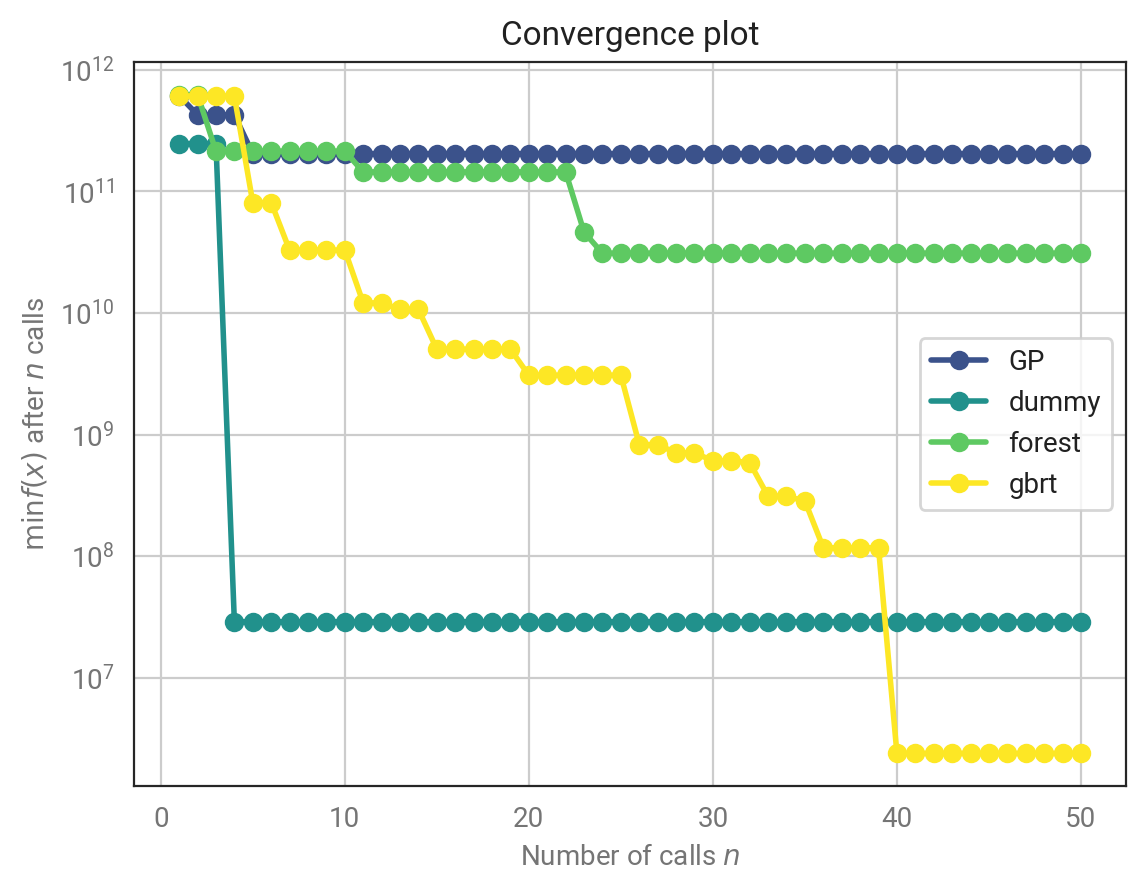

In [31]:
from skopt.plots import plot_convergence
plot_convergence(gp_res, dummy_res, forest_res, gbrt_res)
plt.yscale('log')
plt.legend(['GP', 'dummy', 'forest', 'gbrt'])